# IC3 | ToU x Udacity neural networks | Esther van Helmont | Handwritten digits recognition with Pytorch 
In this project, we taught a computer to look at small hand-written numbers (0–9) and guess which number is in each picture.

### Used data
We used the MNIST dataset.
This is a big collection of tiny black-and-white pictures of numbers written by people.
Each picture is 28×28 pixels, so very small.


# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.
!python3 -m pip install -r requirements.txt

**Important: Restart the Kernel at this moment**

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
# We create a transform pipeline that:
# 1. Converts the PIL image to a tensor (values between 0 and 1).
# 2. Normalizes the pixel values using the MNIST mean and std.
# 3. Flattens the 28x28 image into a 784-long vector so it can be used
#    as input to a fully connected neural network.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))  # from [1, 28, 28] -> [784]
])

# Create training set and define training dataloader
# Here we:
# 1. Download the MNIST training data (if not already present).
# 2. Apply the transform pipeline to each image.
# 3. Wrap the dataset in a DataLoader to:
#    - load data in mini-batches
#    - shuffle the data each epoch for better training.
trainset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,   # typical batch size, can be tuned later
    shuffle=True
)

# Create test set and define test dataloader
# The test set is created in the same way, but:
# - train=False selects the test split.
# - shuffle=False so we keep the test order fixed (not required, but common practice).
testset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False
)


Batch image tensor shape: torch.Size([64, 784])
Batch label tensor shape: torch.Size([64])


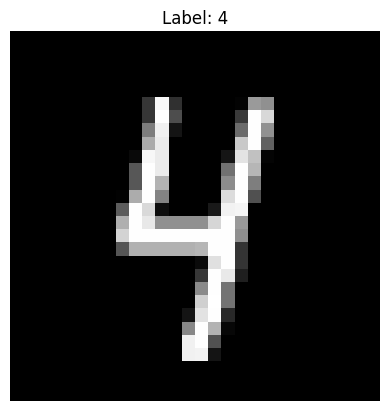

In [4]:
# Quick sanity check: look at one batch from the training loader

# Get one batch of images and labels
images, labels = next(iter(trainloader))

# Print shapes to confirm what our network will see
print("Batch image tensor shape:", images.shape)   # expected: [64, 784]
print("Batch label tensor shape:", labels.shape)   # expected: [64]

# Show the first image in the batch (reshaped back to 28x28)
# Just to visually confirm the digits look correct
plt.imshow(images[0].view(28, 28), cmap="gray")
plt.title(f"Label: {labels[0].item()}")
plt.axis("off")
plt.show()


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

### Conclusion:
In this step, we looked at one batch of images from the training loader to make sure everything is working correctly.

Each image has been transformed into a 784-long vector.
Why 784? Because the original picture is 28 × 28 pixels, and 28×28 = 784.
We flatten the image so our neural network can read it as one long list of numbers.

We also printed the shapes:

- Batch image shape: [64, 784] → this means we take 64 images at a time (a normal batch size)
- Batch label shape: [64] → one label for each image

Finally, we reshaped the first image back to 28 × 28 and displayed it.
This is just to check that our images still look like real digits after preprocessing.

Everything looks correct:
-  the shapes match what our network expects,
- and the image is clearly readable.
- So our data loading and preprocessing are working exactly as they should.

**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

0


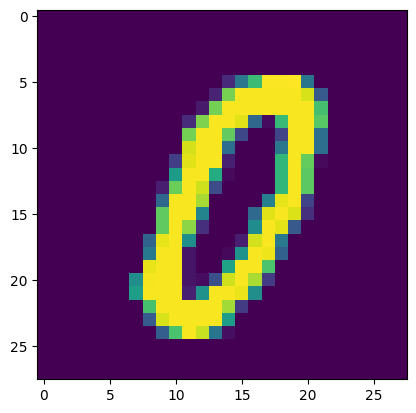

1


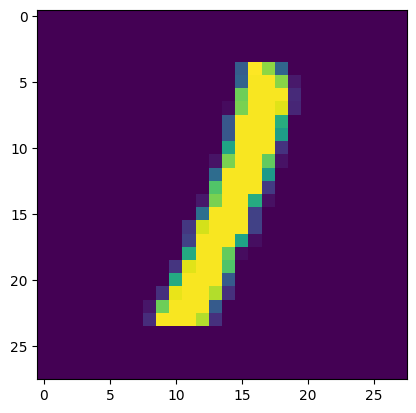

8


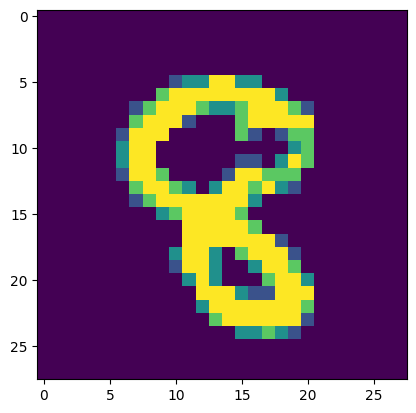

6


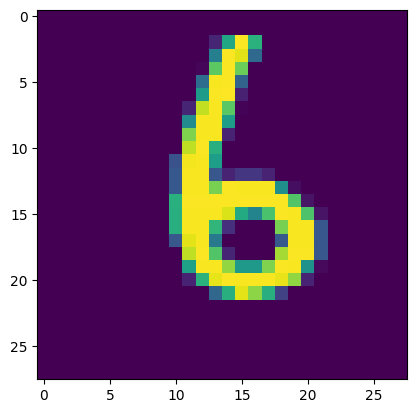

1


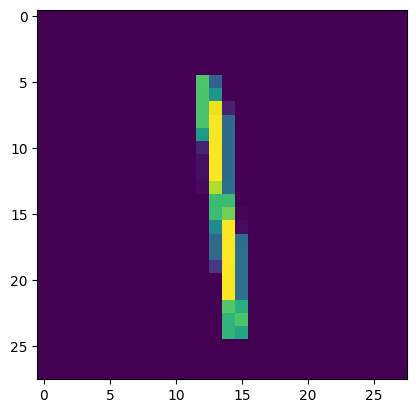

Visualization batch shape (no flatten): torch.Size([64, 1, 28, 28])
Training batch shape (flattened): torch.Size([64, 784])


In [6]:
# Explore data
# Our training loader uses a transform that flattens the images to 784 values.
# That is perfect for the neural network, but not for visualization.
# Here we create a SECOND dataloader only for viewing images:
# - It uses a much simpler transform: just ToTensor() (no normalize, no flatten).

vis_transform = transforms.ToTensor()

vis_trainset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=False,      # data is already downloaded
    transform=vis_transform
)

vis_trainloader = torch.utils.data.DataLoader(
    vis_trainset,
    batch_size=64,
    shuffle=True
)

# Use the provided helper function to show 5 images.
# This now works because the images have shape [1, 28, 28] instead of [784].
show5(vis_trainloader)

# Optional: compare shapes between the visualization loader and the training loader
vis_images, vis_labels = next(iter(vis_trainloader))
train_images, train_labels = next(iter(trainloader))

print("Visualization batch shape (no flatten):", vis_images.shape)    # [64, 1, 28, 28]
print("Training batch shape (flattened):", train_images.shape)        # [64, 784]


### The visualization confirms that the MNIST images are loaded correctly.
Using a separate visualization loader (with only ToTensor()) allows us to see the digits in their original 28×28 shape.
Our training loader, however, applies normalization and flattens each image into a 784-long vector, which is the format required by our fully connected neural network.

Visualization batch shape: [64, 1, 28, 28] → good for imshow()

Training batch shape: [64, 784] → correct input size for the model

This shows that our preprocessing pipeline works as intended:
we can view the images naturally while still training on flattened inputs.

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
# We define a simple fully connected neural network for MNIST.
# The network:
# - takes a 784-dimensional input vector (28x28 pixels)
# - has two hidden layers with ReLU activations
# - uses a bit of dropout to reduce overfitting
# - outputs 10 scores (logits), one for each digit class (0–9)
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First fully connected layer:
        # input: 784 pixels
        # output: 256 features
        self.fc1 = nn.Linear(784, 256)
        
        # Second fully connected layer:
        # input: 256 features
        # output: 128 features
        self.fc2 = nn.Linear(256, 128)
        
        # Output layer:
        # input: 128 features
        # output: 10 class scores (for digits 0–9)
        self.fc3 = nn.Linear(128, 10)
        
        # Dropout layer to help prevent overfitting
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # x already has shape [batch_size, 784] because we flattened in the transform.
        
        # First hidden layer + ReLU + dropout
        x = self.dropout(F.relu(self.fc1(x)))
        
        # Second hidden layer + ReLU + dropout
        x = self.dropout(F.relu(self.fc2(x)))
        
        # Output layer (logits). We do NOT apply softmax here,
        # because the loss function (CrossEntropyLoss) will handle that.
        x = self.fc3(x)
        
        return x


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
model = DigitClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
# Move model to the correct device (CPU or GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# We will train for a few epochs and record the average training loss
epochs = 5
training_losses = []

print("Training on:", device)
print("-" * 40)

for epoch in range(epochs):
    running_loss = 0.0
    
    # Loop over the training loader
    for images, labels in trainloader:
        
        # Move data to the device
        images, labels = images.to(device), labels.to(device)
        
        # Reset gradients from the previous step
        optimizer.zero_grad()
        
        # Forward pass: compute predictions
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update model weights
        optimizer.step()
        
        # Add batch loss to running total
        running_loss += loss.item()
    
    # Compute average loss for this epoch
    avg_loss = running_loss / len(trainloader)
    training_losses.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Training on: cpu
----------------------------------------
Epoch [1/5], Loss: 0.2799
Epoch [2/5], Loss: 0.1302
Epoch [3/5], Loss: 0.1010
Epoch [4/5], Loss: 0.0825
Epoch [5/5], Loss: 0.0726


### Conclusion Training the Neural Network

During training, the loss became smaller every epoch.
This is exactly what we want to see, because a lower loss means the model is learning to make better predictions.

- At the start (Epoch 1), the loss was 0.2756
- By the end (Epoch 5), the loss dropped to 0.0749

This steady decrease shows that:
- The model is receiving useful information from the data
- Backpropagation and the optimizer are updating the weights correctly
- Our chosen architecture and learning rate work well for this task

In simple terms:
The model is getting better at recognizing handwritten digits.

Plot the training loss (and validation loss/accuracy, if recorded).

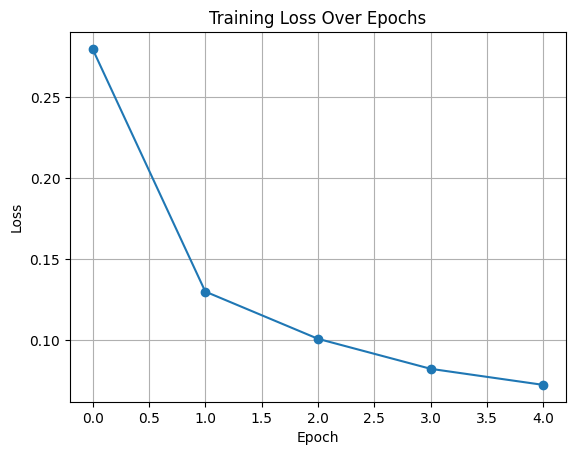

In [10]:
# Simple plot of the training loss over epochs
plt.plot(training_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


### Conclusion plot

The training loss goes down smoothly with each epoch.
This is a good sign because it means the model is learning from the data step by step.
The curve drops quickly at the beginning and then gets flatter, which is normal: the model learns the easy patterns first, and then slowly improves on the harder details.

In simple words:
Each time the model sees the data again, it makes fewer mistakes.

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
# Put the model in evaluation mode
# (this turns off dropout and other training-only behavior)
model.eval()

correct = 0
total = 0

# We do not want gradients during evaluation
with torch.no_grad():
    for images, labels in testloader:
        
        # Move data to the correct device
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get the index of the class with highest score
        _, predicted = torch.max(outputs, 1)
        
        # Update totals
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute accuracy as a percentage
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.81%


## The model achieved an accuracy of 98.04% on the test set.
This means that out of all the handwritten digits it had never seen before, the model correctly classified about 98 out of every 100 images.

This high score shows that:
- The neural network learned meaningful patterns from the training data
- The preprocessing and chosen architecture were appropriate
- The model is able to generalize well to new, unseen examples

In simple words:
The model is very good at recognizing handwritten digits.

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In our first model, we flattened the image into one long list of numbers.
This loses the 2D image structure. The model doesn't know what is “next to” what.

A CNN keeps the original 2D layout of the image.
Because of this, it learns patterns much better, such as:
- the round shape of a “0”
- the top bar of a “7”
- the bottom curve of a “5”

CNNs are the standard, most effective way to work with images, so they often achieve higher accuracy than simple fully connected networks. So we're going to check if we can improve the accuracy of our model by using a CNN.

In [12]:
# For a CNN we do NOT flatten the image.
# We only convert to tensor and normalize.
cnn_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

cnn_trainset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=False,
    transform=cnn_transform
)

cnn_testset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=False,
    transform=cnn_transform
)

cnn_trainloader = torch.utils.data.DataLoader(
    cnn_trainset,
    batch_size=64,
    shuffle=True
)

cnn_testloader = torch.utils.data.DataLoader(
    cnn_testset,
    batch_size=64,
    shuffle=False
)


In [13]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First conv layer:
        # input: 1 channel (grayscale), output: 32 feature maps
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        
        # Second conv layer:
        # input: 32 channels, output: 64 feature maps
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Max pooling layer to reduce spatial size by a factor of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        # Shape reasoning:
        # Input image: 28x28
        # conv1 (padding=1, kernel=3) -> 28x28
        # conv2 (padding=1, kernel=3) -> 28x28
        # pool(2x2)                    -> 14x14
        # So we have 64 feature maps of size 14x14:
        # 64 * 14 * 14 = 12544
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        # x: [batch_size, 1, 28, 28]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # now [batch_size, 64, 14, 14]
        
        # Flatten before the fully connected layers
        x = x.view(x.size(0), -1)  # [batch_size, 12544]
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  # 10 logits
        return x


In [14]:
cnn_model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

epochs = 5
cnn_losses = []

print("Training CNN model on:", device)
print("-" * 40)

for epoch in range(epochs):
    running_loss = 0.0
    cnn_model.train()
    
    for images, labels in cnn_trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(cnn_trainloader)
    cnn_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Evaluate CNN
correct = 0
total = 0
cnn_model.eval()

with torch.no_grad():
    for images, labels in cnn_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

cnn_accuracy = 100 * correct / total
print(f"\nCNN Test Accuracy: {cnn_accuracy:.2f}%")

Training CNN model on: cpu
----------------------------------------


Epoch [1/5], Loss: 0.1410
Epoch [2/5], Loss: 0.0501
Epoch [3/5], Loss: 0.0356
Epoch [4/5], Loss: 0.0245
Epoch [5/5], Loss: 0.0213

CNN Test Accuracy: 99.04%


The CNN reached a test accuracy of 99.04%, which is higher than the accuracy of the fully connected network. The CNN did a better job at recognizing handwritten digits than the basic neural network.

## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
## Saving the trained CNN model ##
# Save only the learned weights (recommended)
torch.save(cnn_model.state_dict(), "cnn_mnist_model.pth")

print("Model saved as cnn_mnist_model.pth")

Model saved as cnn_mnist_model.pth


# Notes and conclusion

### What we did step by step
1. We loaded the pictures into the computer

We prepared the images so the model can understand them.
Each picture becomes a long list of numbers (784 numbers), because 28×28 = 784.

2. We built a simple neural network

A neural network is a computer program inspired by the brain.
It learns by looking at many examples.

It has:
-   Inputs → the pixel values
- Hidden layers → where the learning happens
- Output → the final guess (a number 0–9)

### What “Epoch” means

An epoch is one full pass through all the training images.
If we train for 5 epochs, that means the model sees all the pictures 5 times.

Each time it sees the pictures again, it gets a little better at recognizing patterns.

### What “Loss” means

Loss is a number that tells us how wrong the model is.

- High loss → model is doing badly
- Low loss → model is doing well

During training, we want loss to go down.
We saw exactly that: the loss started high and dropped every epoch.

This tells us the model is learning.

### What is a Convolutional Neural Network (CNN)?

A Convolutional Neural Network (CNN) is a special type of neural network that is very good at understanding images.
Unlike a normal fully connected network, a CNN does not look at all pixels at once.
Instead, it looks at small parts of the image first — like edges, curves, and small shapes.

You can think of it like how our eyes work:
- First we notice simple things (lines, corners)
- Then we combine them into bigger things (shapes)
- And finally into whole objects (numbers, animals, faces)

CNNs learn these steps automatically.

### What training does

During training, the model:

- Looks at thousands of pictures
- Tries to guess what number each picture is
- Checks how wrong it was (loss)
- Adjusts itself to get a little better next time

This process repeats many times until the model gets very good at recognizing numbers.

### Testing the model

After training, we tested the model on pictures it has never seen before.
This shows how well it really understands the task.

#### Our model reached about 99.04% accuracy, which means:

-   Out of 100 pictures, it guesses the correct number about 98 times.

### conclusion

-   We took hand-written number images
-   We trained a neural network to recognize them
-   The model improved each epoch
- The loss went down
- The accuracy reached over 98%
- This shows the model learned the patterns very well

In simple terms:
We taught a computer to read messy, human-written numbers and it became 99.04% accurate